# Sentiment Analysis

Let us start by importing all the libraries we need

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

plt.style.use('ggplot')

import nltk

Let us read the file provided using pandas

In [8]:
file_path = r'C:\Users\arnav\OneDrive\Pictures\Documents\Reviews.csv'

df = pd.read_csv(file_path)
print(df.shape)

df = df.head(500)
print(df.shape)


(568454, 10)
(500, 10)


Just printing the first few rows for us to have an idea of the data

In [9]:
df.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

For our visual understanding, let us plot the stars of all the reviews we have

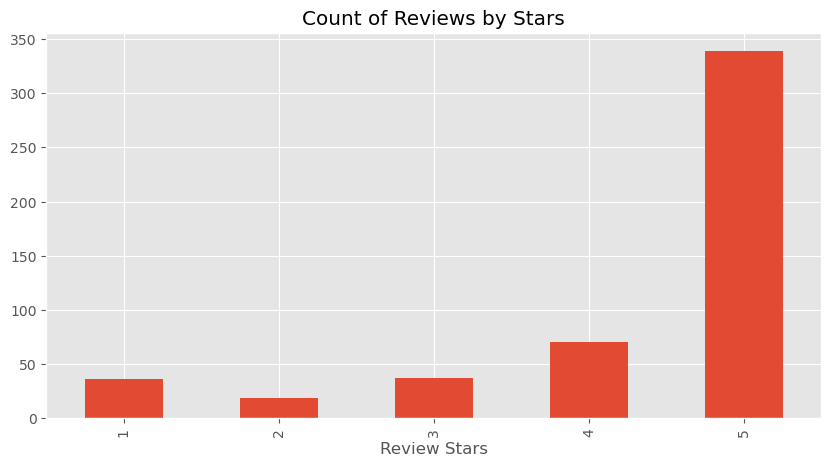

In [10]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Basic NLTK

In [11]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


We can tokenize the words of a sentence. Tokenize is basically break the sentence into parts the machine understands

In [12]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

NLTK also has the ability to detemine the part of speech for every word

In [13]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

Then we identify and group named entities (like people, organizations, places) from POS-tagged text and displays them in a tree format.

In [14]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## Step 1. VADER Seniment Scoring

We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.

* This uses a "bag of words" approach:
* Stop words are removed
* Each word is scored and combined to a total score.

In [15]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

Let us run some exaples to test this

In [16]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

We see that this has a 0 negative value. Compound score is overall positive. Let us run this on a traditionally negative statement

In [17]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

Let us now run the polarity score on the entire dataset

In [56]:
from tqdm.auto import tqdm
import pandas as pd

res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    scores = sia.polarity_scores(text)
    res[myid] = scores  

100%|██████████| 500/500 [00:01<00:00, 357.99it/s]


Now we have a sentiment score and a MetaData

In [33]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left', on='Id')

In [34]:
vaders.head()

Id    neg    neu    pos  compound   ProductId          UserId  \
0   1  0.000  0.695  0.305    0.9441  B001E4KFG0  A3SGXH7AUHU8GW   
1   2  0.138  0.862  0.000   -0.5664  B00813GRG4  A1D87F6ZCVE5NK   
2   3  0.091  0.754  0.155    0.8265  B000LQOCH0   ABXLMWJIXXAIN   
3   4  0.000  1.000  0.000    0.0000  B000UA0QIQ  A395BORC6FGVXV   
4   5  0.000  0.552  0.448    0.9468  B006K2ZZ7K  A1UQRSCLF8GW1T   

                       ProfileName  HelpfulnessNumerator  \
0                       delmartian                     1   
1                           dll pa                     0   
2  Natalia Corres "Natalia Corres"                     1   
3                             Karl                     3   
4    Michael D. Bigham "M. Wassir"                     0   

   HelpfulnessDenominator  Score        Time                Summary  \
0                       1      5  1303862400  Good Quality Dog Food   
1                       0      1  1346976000      Not as Advertised   
2                       1      4  1219017600  "Delight" says it all   
3                       3      2  1307923200         Cough Medicine   
4                       0      5  1350777600            Great taffy   

                                                Text  
0  I have bought several of the Vitality canned d...  
1  Product arrived labeled as Jumbo Salted Peanut...  
2  This is a confection that has been around a fe...  
3  If you are looking for the secret ingredient i...  
4  Great taffy at a great price.  There was a wid...

### Let us plot the results we got by VADER

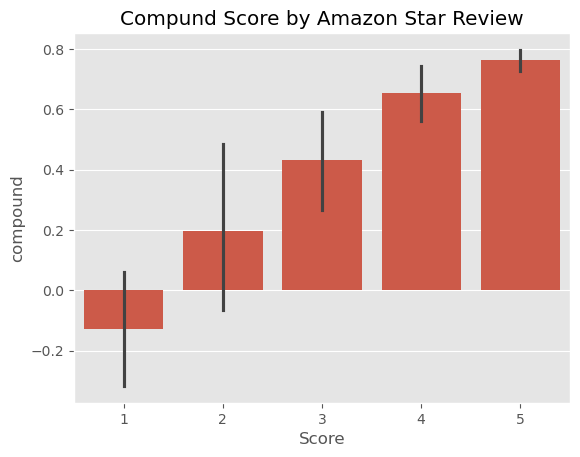

In [35]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

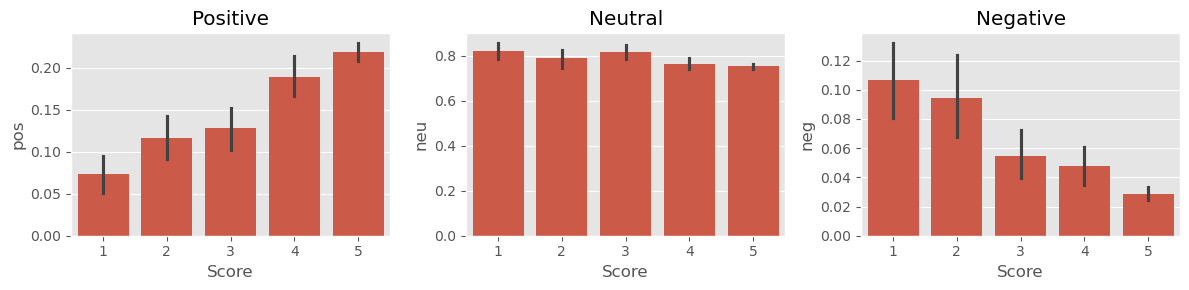

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

## Let us now use a Roberta Pretrained Model

* Use a model trained of a large corpus of data.
* Transformer model accounts for the words but also the context related to other words.

In [38]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax


Let us run this model now

In [39]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

To compare both models lets see how the VADER model scored our example and then compare it with the Roberta model

In [40]:
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [41]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': np.float32(0.97635514), 'roberta_neu': np.float32(0.020687466), 'roberta_pos': np.float32(0.0029573692)}


We see that the Roberta model is much more accurate in predicting the sentiment of something

In [42]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [43]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

 16%|█▋        | 82/500 [00:49<01:34,  4.43it/s]

Broke for id 83


 38%|███▊      | 188/500 [01:16<00:53,  5.83it/s]

Broke for id 187


100%|██████████| 500/500 [02:58<00:00,  2.80it/s]


### Compare scores between models

In [44]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [45]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

## Combine and Compare

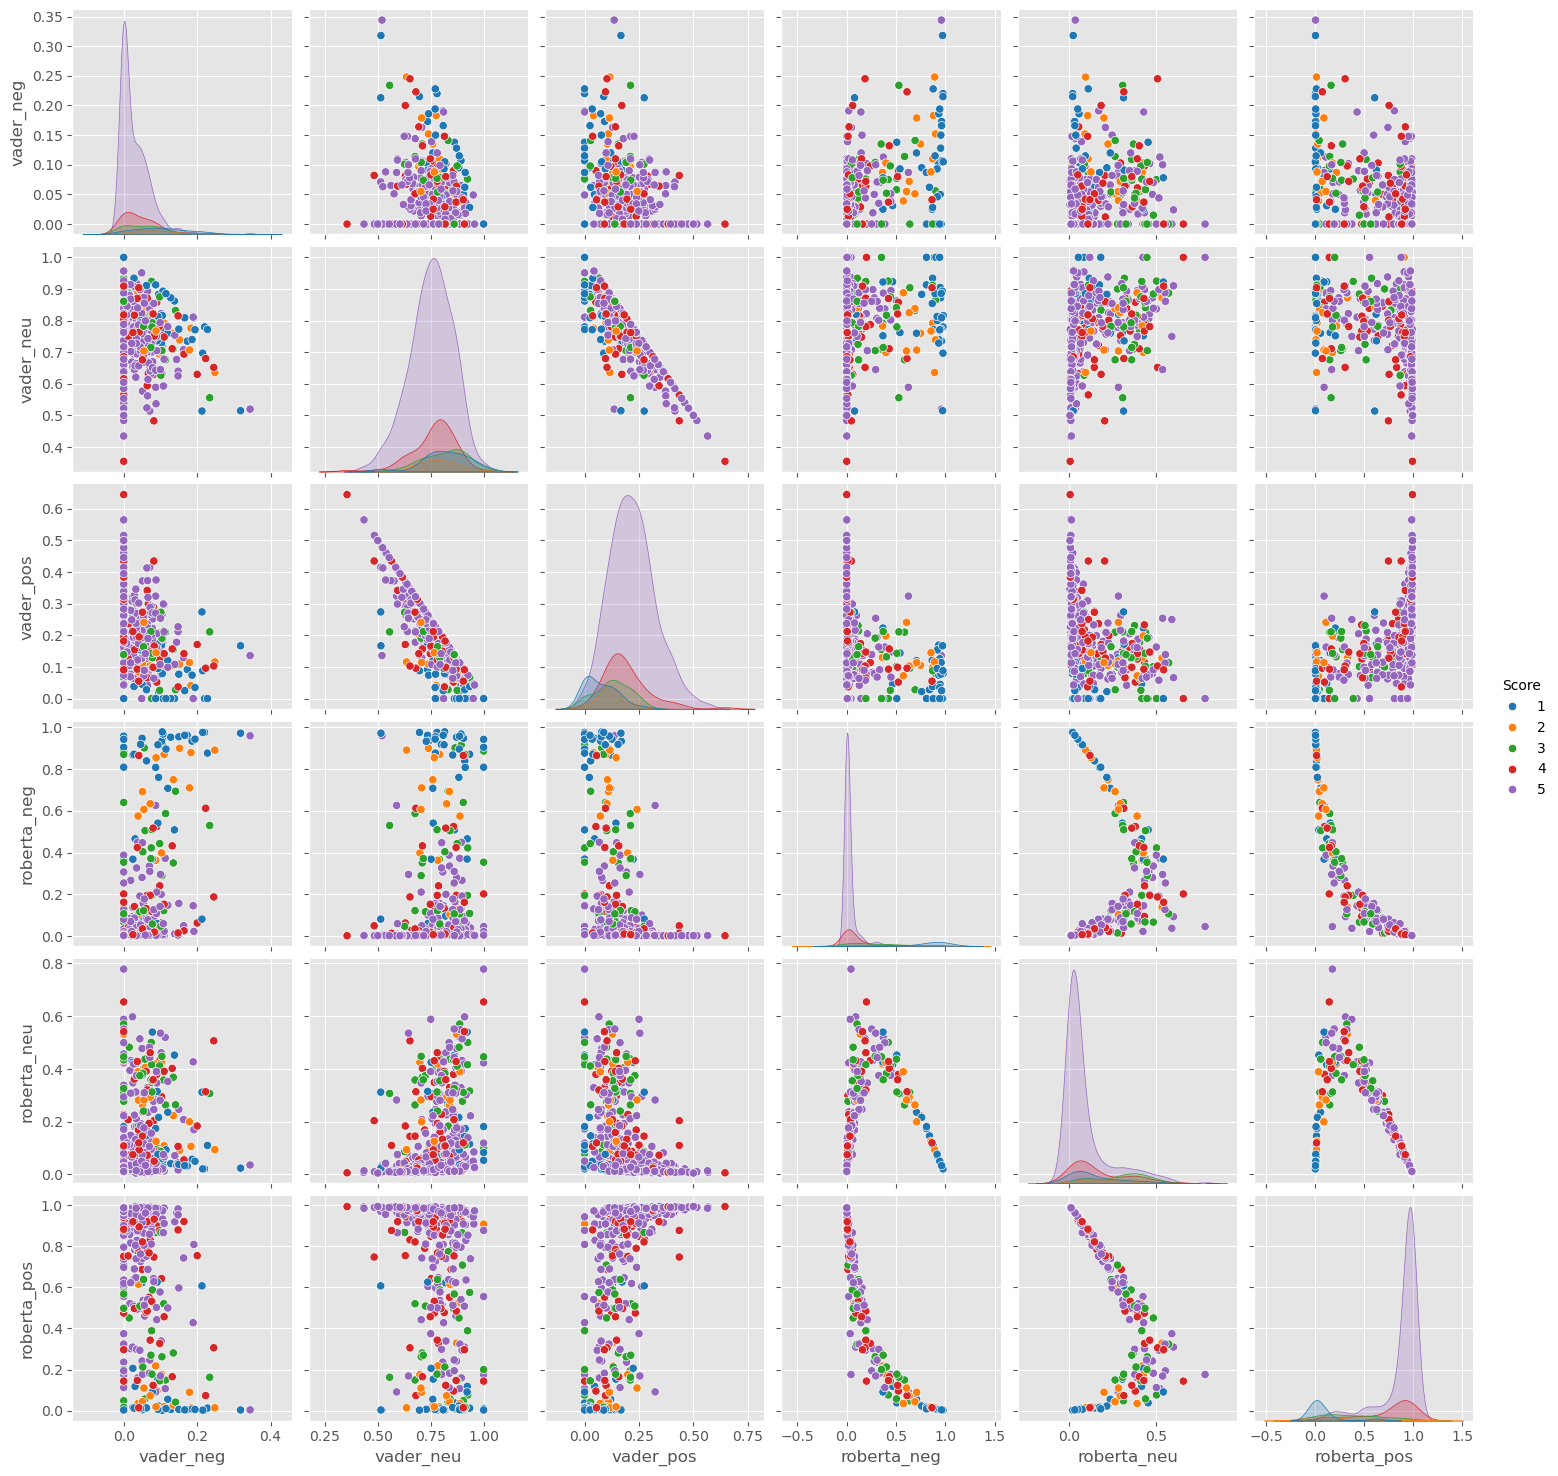

In [46]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

Based on the graphs, we see that the Roberta model is just in general more confident while its predicting compared to the VADER model where a lot of the data is all over the place

## Review Examples

* Positive 1-Star and Negative 5-Star Reviews
* Lets look at some examples where the model scoring and review score differ the most.

In [47]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [48]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

nevative sentiment 5-Star view

In [49]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [50]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

## The Transformers Pipeline

Quick & easy way to run sentiment predictions

In [53]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


In [52]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [54]:
sent_pipeline('Make sure to like and subscribe!')

[{'label': 'POSITIVE', 'score': 0.9991742968559265}]

In [55]:
sent_pipeline('booo')

[{'label': 'NEGATIVE', 'score': 0.9936267137527466}]

## Some model evaluations

In [60]:
def score_to_sentiment(score):
    if score <= 2:
        return 'negative'
    elif score == 3:
        return 'neutral'
    else:
        return 'positive'

results_df['actual_sentiment'] = results_df['Score'].apply(score_to_sentiment)


In [61]:
results_df['vader_sentiment'] = results_df['vader_compound'].apply(
    lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral')
)


In [62]:
def roberta_label(row):
    scores = {
        'negative': row['roberta_neg'],
        'neutral': row['roberta_neu'],
        'positive': row['roberta_pos']
    }
    return max(scores, key=scores.get)

results_df['roberta_sentiment'] = results_df.apply(roberta_label, axis=1)


VADER Classification Report
              precision    recall  f1-score   support

    negative       0.54      0.46      0.50        54
     neutral       0.25      0.11      0.15        37
    positive       0.88      0.95      0.91       407

    accuracy                           0.83       498
   macro avg       0.56      0.51      0.52       498
weighted avg       0.80      0.83      0.81       498



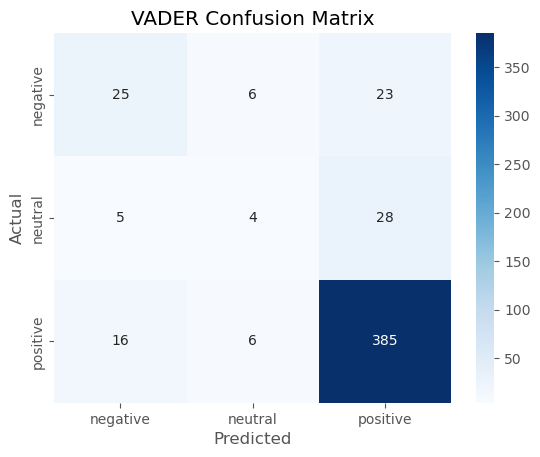


RoBERTa Classification Report
              precision    recall  f1-score   support

    negative       0.66      0.78      0.71        54
     neutral       0.23      0.22      0.22        37
    positive       0.94      0.92      0.93       407

    accuracy                           0.86       498
   macro avg       0.61      0.64      0.62       498
weighted avg       0.86      0.86      0.86       498



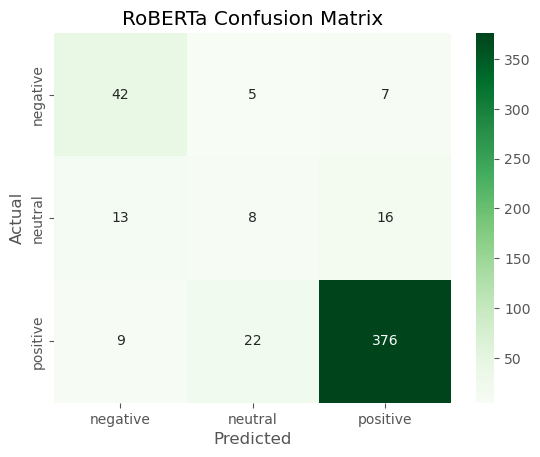

In [63]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# VADER Evaluation
print("VADER Classification Report")
print(classification_report(results_df['actual_sentiment'], results_df['vader_sentiment']))

sns.heatmap(confusion_matrix(results_df['actual_sentiment'], results_df['vader_sentiment']), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.title('VADER Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# RoBERTa Evaluation
print("\nRoBERTa Classification Report")
print(classification_report(results_df['actual_sentiment'], results_df['roberta_sentiment']))

sns.heatmap(confusion_matrix(results_df['actual_sentiment'], results_df['roberta_sentiment']), 
            annot=True, fmt='d', cmap='Greens',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.title('RoBERTa Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [66]:
vader_acc = accuracy_score(results_df['actual_sentiment'], results_df['vader_sentiment'])
roberta_acc = accuracy_score(results_df['actual_sentiment'], results_df['roberta_sentiment'])

print(f"VADER Accuracy: {vader_acc:.3f}")
print(f"RoBERTa Accuracy: {roberta_acc:.3f}")


VADER Accuracy: 0.831
RoBERTa Accuracy: 0.855


In [65]:
from scipy.stats import pearsonr

# Estimate score: positive - negative
results_df['roberta_score_diff'] = results_df['roberta_pos'] - results_df['roberta_neg']
results_df['vader_score'] = results_df['vader_compound']  # already in results_df

vader_corr = pearsonr(results_df['vader_score'], results_df['Score'])
roberta_corr = pearsonr(results_df['roberta_score_diff'], results_df['Score'])

print(f"VADER score vs star rating correlation: {vader_corr[0]:.3f}")
print(f"RoBERTa score vs star rating correlation: {roberta_corr[0]:.3f}")


VADER score vs star rating correlation: 0.535
RoBERTa score vs star rating correlation: 0.775


## Sentiment Analysis Evaluation: VADER vs RoBERTa

### Objective
We compared two sentiment analysis models VADER (rule-based) and RoBERTa (transformer-based) on a dataset of Amazon product reviews, using the review star ratings as ground truth.

---

### Quantitative Metrics

| Metric                      | VADER      | RoBERTa    |
|----------------------------|------------|------------|
| Accuracy                   | 83.1%      | **85.5%**  |
| Pearson Correlation (Score vs Sentiment Score) | 0.535      | **0.775**  |

---

### Interpretation

- **Accuracy**: Both models perform well overall, but RoBERTa shows a clear edge with a +2.4% improvement in accuracy.
  
- **Correlation with Actual Ratings**:
  - VADER’s sentiment scores moderately correlate with the review star ratings (ρ = 0.535), indicating that it captures overall polarity but misses finer distinctions.
  - RoBERTa achieves a **strong correlation** (ρ = 0.775), suggesting that its sentiment predictions align much more closely with user-assigned star ratings.

- **Strengths of RoBERTa**:
  - Better at capturing **contextual sentiment** and **nuance** (e.g., sarcasm, negations).
  - Handles **subtle polarity** shifts better than lexicon-based methods like VADER.

- **Weaknesses of VADER**:
  - Strongly biased toward **positive sentiment**.
  - Fails to correctly classify many **negative or neutral** reviews (as seen in F1 scores and confusion matrix).
  - Doesn't generalize well for domain-specific language.

---

### Conclusion

RoBERTa clearly outperforms VADER in both **accuracy** and **correlation with ground truth**. While VADER is lightweight and fast, RoBERTa is much better suited for tasks that require **fine-grained and reliable sentiment understanding**, especially in product reviews or customer feedback.

> **Recommendation**: For production-level sentiment classification in review-based datasets, RoBERTa (or similar transformer-based models) should be the preferred choice.
